In [1]:
import time
import torch

import pathpy as pp2
import pathpyG as pp
from matplotlib import pyplot as plt

print('Running on', pp.config['torch']['device'])

Running on cpu


In [3]:
p = pp.WalkData.from_csv('../data/tube_paths_train.ngram')
g2 = pp.HigherOrderGraph(p, order=2, path_freq='path_freq')
print(g2.N)
print(g2.M)
print(g2['edge_weight'].sum().item())

642
1139
12356472.0


In [4]:
for e in g2.edges:
    print(e, g2['edge_weight', e[0], e[1]])

(('Southwark', 'Waterloo'), ('Waterloo', 'Westminster')) tensor(91710.)
(('Southwark', 'Waterloo'), ('Waterloo', 'Embankment')) tensor(8405.)
(('Southwark', 'Waterloo'), ('Waterloo', 'Kennington')) tensor(13182.)
(('Southwark', 'Waterloo'), ('Waterloo', 'Lambeth North')) tensor(204.)
(('Southwark', 'London Bridge'), ('London Bridge', 'Bank / Monument')) tensor(73218.)
(('Southwark', 'London Bridge'), ('London Bridge', 'Borough')) tensor(296.)
(('Southwark', 'London Bridge'), ('London Bridge', 'Bermondsey')) tensor(51530.)
(('Waterloo', 'Southwark'), ('Southwark', 'London Bridge')) tensor(140333.)
(('Waterloo', 'Embankment'), ('Embankment', 'Charing Cross')) tensor(11663.)
(('Waterloo', 'Embankment'), ('Embankment', 'Temple')) tensor(1499.)
(('Waterloo', 'Westminster'), ('Westminster', "St. James's Park")) tensor(19691.)
(('Waterloo', 'Westminster'), ('Westminster', 'Green Park')) tensor(103374.)
(('Waterloo', 'Lambeth North'), ('Lambeth North', 'Elephant & Castle')) tensor(3719.)
(('Wa

In [5]:
g2['edge_weight', ('Southwark', 'Waterloo'), ('Waterloo', 'Embankment')]

tensor(8405.)

In [6]:
paths = pp2.Paths.read_file("../data/tube_paths_train.ngram", max_subpath_length=2)
g2 = pp2.HigherOrderNetwork(paths, k=2)
print(g2)

2024-02-23 11:58:51 [Severity.INFO]	Reading ngram data ... 
2024-02-23 11:58:52 [Severity.INFO]	finished. Read 61748 paths with maximum length 35
2024-02-23 11:58:52 [Severity.INFO]	Calculating sub path statistics ... 
2024-02-23 11:58:53 [Severity.INFO]	finished.
Higher-order network of order k = 2

Nodes:				646
Links:				1139
Total weight (subpaths/longest paths):	12182604.0/173868.0



# Pathpy 2.0

2024-02-23 11:59:16 [Severity.INFO]	Reading ngram data ... 
2024-02-23 11:59:17 [Severity.INFO]	finished. Read 61748 paths with maximum length 35
2024-02-23 11:59:17 [Severity.INFO]	Calculating sub path statistics ... 
2024-02-23 11:59:17 [Severity.INFO]	finished.
Higher-order network of order k = 1

Nodes:				268
Links:				646
Total weight (subpaths/longest paths):	14404381.0/99956.0

2024-02-23 11:59:17 [Severity.INFO]	Reading ngram data ... 
2024-02-23 11:59:18 [Severity.INFO]	finished. Read 61748 paths with maximum length 35
2024-02-23 11:59:18 [Severity.INFO]	Calculating sub path statistics ... 
2024-02-23 11:59:19 [Severity.INFO]	finished.
Higher-order network of order k = 2

Nodes:				646
Links:				1139
Total weight (subpaths/longest paths):	12182604.0/173868.0

2024-02-23 11:59:19 [Severity.INFO]	Reading ngram data ... 
2024-02-23 11:59:20 [Severity.INFO]	finished. Read 61748 paths with maximum length 35
2024-02-23 11:59:20 [Severity.INFO]	Calculating sub path statistics ... 
2

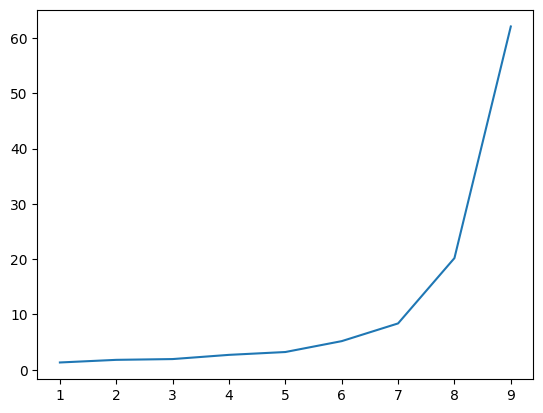

In [7]:
ks = range(1,10)
times = []
for k in ks:
    start = time.time() 
    paths = pp2.Paths.read_file("../data/tube_paths_train.ngram", max_subpath_length=k)
    g2 = pp2.HigherOrderNetwork(paths, k=k)
    print(g2)
    elapsed_pp = time.time()-start
    times.append(elapsed_pp)
plt.plot(ks, times)

# pathpyG (GPU)

In [8]:
pp.config['torch']['device'] = 'cuda:0'

In [9]:
ks = range(1,10)
times_new_gpu = []
for k in ks:
    start = time.time()
    p = pp.WalkData.from_csv('../data/tube_paths_train.ngram')
    gk = pp.HigherOrderGraph(p, order=k, path_freq='path_freq')
    print(gk)
    print('---')
    elapsed_new = time.time()-start
    times_new_gpu.append(elapsed_new)

HigherOrderGraph (k=1) with 268 nodes and 646 edges
	Total edge weight = 14504337.0
Edge attributes
	edge_weight		<class 'torch.Tensor'> -> torch.Size([646])

Graph attributes
	num_nodes		<class 'int'>
	path_freq		<class 'str'>

---
HigherOrderGraph (k=2) with 642 nodes and 1139 edges
	Total edge weight = 12356472.0
Edge attributes
	edge_weight		<class 'torch.Tensor'> -> torch.Size([1139])

Graph attributes
	num_nodes		<class 'int'>
	path_freq		<class 'str'>

---
HigherOrderGraph (k=3) with 1134 nodes and 1869 edges
	Total edge weight = 10308563.0
Edge attributes
	edge_weight		<class 'torch.Tensor'> -> torch.Size([1869])

Graph attributes
	num_nodes		<class 'int'>
	path_freq		<class 'str'>

---
HigherOrderGraph (k=4) with 1812 nodes and 2730 edges
	Total edge weight = 8434522.0
Edge attributes
	edge_weight		<class 'torch.Tensor'> -> torch.Size([2730])

Graph attributes
	num_nodes		<class 'int'>
	path_freq		<class 'str'>

---
HigherOrderGraph (k=5) with 2576 nodes and 3683 edges
	Total 

In [10]:
pp.config['torch']['device'] = 'cpu'

In [11]:
ks = range(1,10)
times_new_cpu = []
for k in ks:
    start = time.time()
    p = pp.WalkData.from_csv('../data/tube_paths_train.ngram')
    gk = pp.HigherOrderGraph(p, order=k, path_freq='path_freq')
    print(gk)
    print('---')
    elapsed_new = time.time()-start
    times_new_cpu.append(elapsed_new)

HigherOrderGraph (k=1) with 268 nodes and 646 edges
	Total edge weight = 14504337.0
Edge attributes
	edge_weight		<class 'torch.Tensor'> -> torch.Size([646])

Graph attributes
	num_nodes		<class 'int'>
	path_freq		<class 'str'>

---
HigherOrderGraph (k=2) with 642 nodes and 1139 edges
	Total edge weight = 12356472.0
Edge attributes
	edge_weight		<class 'torch.Tensor'> -> torch.Size([1139])

Graph attributes
	num_nodes		<class 'int'>
	path_freq		<class 'str'>

---
HigherOrderGraph (k=3) with 1134 nodes and 1869 edges
	Total edge weight = 10308563.0
Edge attributes
	edge_weight		<class 'torch.Tensor'> -> torch.Size([1869])

Graph attributes
	num_nodes		<class 'int'>
	path_freq		<class 'str'>

---
HigherOrderGraph (k=4) with 1812 nodes and 2730 edges
	Total edge weight = 8434522.0
Edge attributes
	edge_weight		<class 'torch.Tensor'> -> torch.Size([2730])

Graph attributes
	num_nodes		<class 'int'>
	path_freq		<class 'str'>

---
HigherOrderGraph (k=5) with 2576 nodes and 3683 edges
	Total 

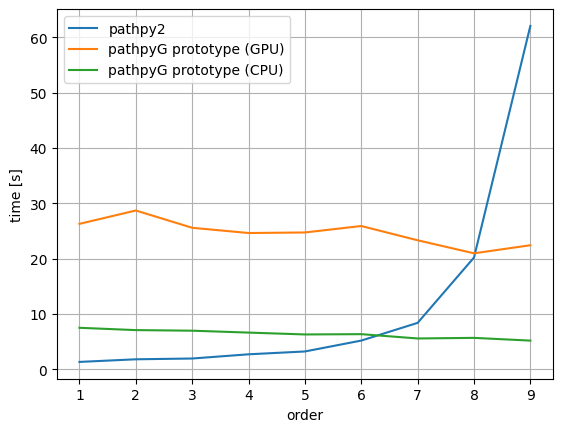

In [12]:
plt.plot(ks, times, label='pathpy2')
plt.plot(ks, times_new_gpu, label='pathpyG prototype (GPU)')
plt.plot(ks, times_new_cpu, label='pathpyG prototype (CPU)')
plt.xlabel('order')
plt.grid()
plt.ylabel('time [s]')
plt.legend()

(1, 100)

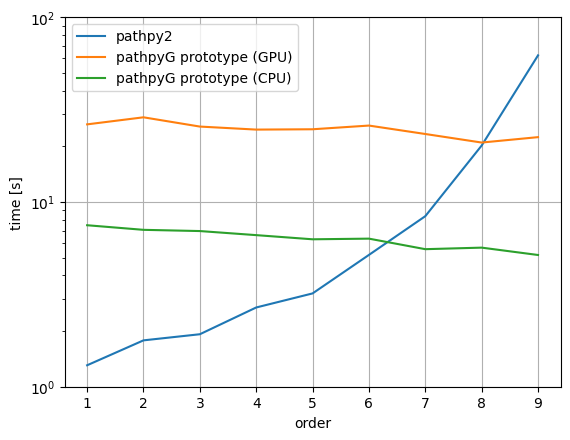

In [13]:
plt.plot(ks, times, label='pathpy2')
plt.plot(ks, times_new_gpu, label='pathpyG prototype (GPU)')
plt.plot(ks, times_new_cpu, label='pathpyG prototype (CPU)')
plt.xlabel('order')
plt.ylabel('time [s]')
plt.legend()
plt.grid()
plt.yscale('log')
plt.ylim(1,100)